In [1]:
import sys

import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

%matplotlib inline

pd.options.display.max_rows = 15

warnings.filterwarnings('ignore')

In [2]:
original_data = pd.read_csv('data/train.csv', index_col='PassengerId')

In [3]:
original_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
...,...,...,...,...,...,...,...,...,...,...,...
885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S


In [4]:
original_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
original_data.isnull().sum().sort_values()

Survived      0
Pclass        0
Name          0
Sex           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      2
Age         177
Cabin       687
dtype: int64

In [6]:
df = original_data.copy(deep=True)

Първоначално разглеждаме името. От него ще извлечем всички титли, с които да попълним липсващите възрасти.

In [7]:
df['Name']

PassengerId
1                                Braund, Mr. Owen Harris
2      Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                 Heikkinen, Miss. Laina
4           Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                               Allen, Mr. William Henry
6                                       Moran, Mr. James
7                                McCarthy, Mr. Timothy J
                             ...                        
885                               Sutehall, Mr. Henry Jr
886                 Rice, Mrs. William (Margaret Norton)
887                                Montvila, Rev. Juozas
888                         Graham, Miss. Margaret Edith
889             Johnston, Miss. Catherine Helen "Carrie"
890                                Behr, Mr. Karl Howell
891                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [8]:
df['Title'] = df.Name.str.extract('([A-Za-z]+)\.', expand=False)

In [9]:
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

Сега заместваме всички титли със съответно: Mr (за мъже), Miss (госпожици), Mrs (госпожи), Master (деца). Разликата е, че тук разпределям всички титли да са Mr, Miss или Mrs, без other.

In [10]:
df['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Mr','Mr','Mr','Mr','Mr','Mr', 'Mrs'],inplace=True)

Запълваме празните. 

In [11]:
df.loc[(df.Age.isnull()) & (df.Title == 'Mr'), 'Age'] = df[df.Title == 'Mr'].Age.mean()
df.loc[(df.Age.isnull()) & (df.Title == 'Mrs'), 'Age'] = df[df.Title == 'Mrs'].Age.mean()
df.loc[(df.Age.isnull()) & (df.Title == 'Miss'), 'Age'] = df[df.Title == 'Miss'].Age.mean()
df.loc[(df.Age.isnull()) & (df.Title == 'Master'), 'Age'] = df[df.Title == 'Master'].Age.mean()

Остават 2 записа без Embarked и 687 без каюта. По-надолу ще разгледаме каютите и какво можем да извлечем от тях.

In [12]:
df.isnull().sum().sort_values()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Title         0
Embarked      2
Cabin       687
dtype: int64

Сега да оправим и embarked.

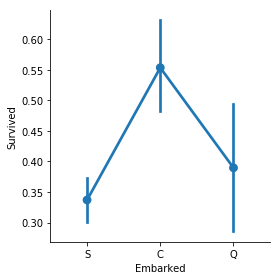

In [13]:
sns.factorplot('Embarked','Survived',data=df)

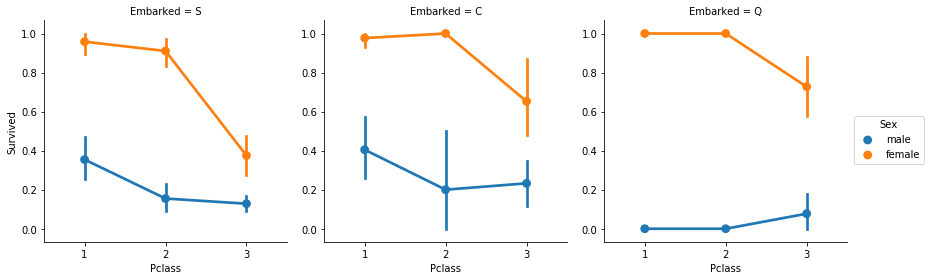

In [14]:
sns.factorplot('Pclass','Survived',hue='Sex',col='Embarked',data=df)

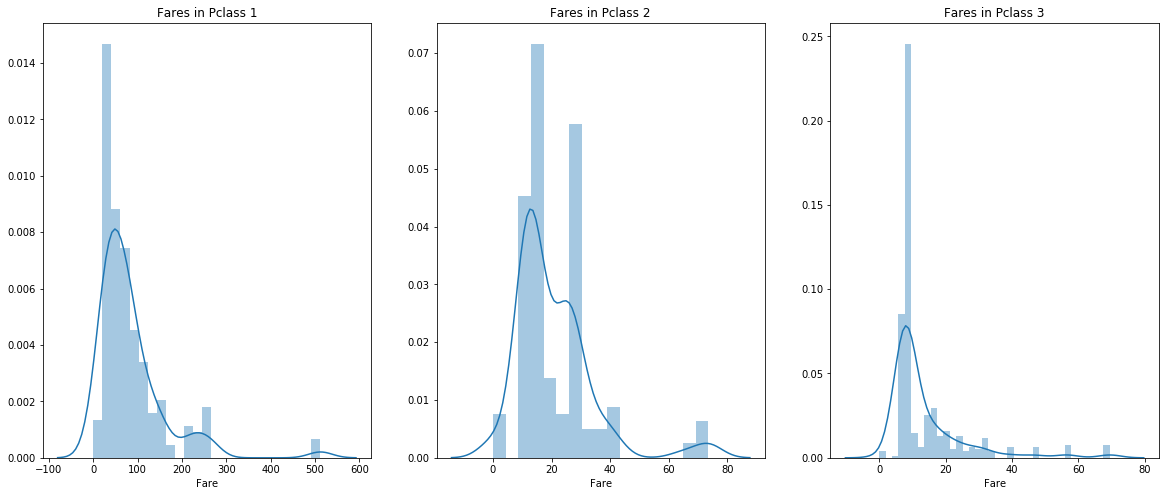

In [15]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(df[df['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(df[df['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(df[df['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

In [16]:
df['Embarked'] = df['Embarked'].fillna('S')

И да one hot encode-нем по простия начин титлите, Embarked и класата.

In [17]:
df['Male']    = (df.Sex == 'male').astype(float)
df['Female']  = (df.Sex == 'female').astype(float)
df['Mr']      = (df.Title == 'Mr').astype(float)
df['Mrs']     = (df.Title == 'Mrs').astype(float)
df['Miss']    = (df.Title == 'Miss').astype(float)
df['Master']  = (df.Title == 'Master').astype(float)
df['EmbarkedC'] = (df.Embarked == 'C').astype(float)
df['EmbarkedQ'] = (df.Embarked == 'Q').astype(float)
df['EmbarkedS'] = (df.Embarked == 'S').astype(float)
df['Class1'] = (df.Pclass == 1).astype(float)
df['Class2'] = (df.Pclass == 2).astype(float)
df['Class3'] = (df.Pclass == 3).astype(float)


df = df.drop(['Embarked', 'Title', 'Pclass'], axis=1)

In [18]:
df.describe()

,Survived,Age,SibSp,Parch,Fare,Male,Female,Mr,Mrs,Miss,Master,EmbarkedC,EmbarkedQ,EmbarkedS,Class1,Class2,Class3
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,29.837087,0.523008,0.381594,32.204208,0.647587,0.352413,0.603816,0.142536,0.208754,0.044893,0.188552,0.086420,0.725028,0.242424,0.206510,0.551066
std,0.486592,13.289076,1.102743,0.806057,49.693429,0.477990,0.477990,0.489378,0.349796,0.406647,0.207186,0.391372,0.281141,0.446751,0.428790,0.405028,0.497665
min,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,21.860000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,30.000000,0.000000,0.000000,14.454200,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,35.981818,1.000000,0.000000,31.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Сега да се заемем с Age. Първо ще пробваме с binning, а след това ще го one hot-нем.

In [19]:
def bin_age(dataframe):
    dataframe.loc[dataframe['Age']<=16,'Age_band']=0
    dataframe.loc[(dataframe['Age']>16)&(dataframe['Age']<=32),'Age_band']=1
    dataframe.loc[(dataframe['Age']>32)&(dataframe['Age']<=48),'Age_band']=2
    dataframe.loc[(dataframe['Age']>48)&(dataframe['Age']<=64),'Age_band']=3
    dataframe.loc[dataframe['Age']>64,'Age_band']=4
    
    dataframe.drop(['Age'],axis=1,inplace=True)

In [20]:
bin_age(df)

In [21]:
def get_x_y(dataframe):
    X = dataframe[dataframe.describe().columns]
    X = X.drop('Survived', 1)
    y = dataframe['Survived']
    
    print('X: {}\ny: {}'.format(X.shape, y.shape))
    
    return (X, y)

Същото и за Fare.

In [22]:
df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

Някои доста са се набутали, а други са минали гратис.

In [23]:
print("fare = 0 : " + str(len(df[df['Fare'] == 0])))
print("fare > 250: " + str(len(df[df['Fare'] > 250])))

fare = 0 : 15
fare > 250: 9


In [24]:
df['Fare_Range']=pd.qcut(df['Fare'],4)
df.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


In [25]:
def bin_fare(dataframe):
    dataframe.loc[dataframe['Fare']<=7.91,'Fare_cat']=0
    dataframe.loc[(dataframe['Fare']>7.91)&(dataframe['Fare']<=14.454),'Fare_cat']=1
    dataframe.loc[(dataframe['Fare']>14.454)&(dataframe['Fare']<=31),'Fare_cat']=2
    dataframe.loc[(dataframe['Fare']>31)&(dataframe['Fare']<=513),'Fare_cat']=3

    dataframe.drop(['Fare'],axis=1,inplace=True)

In [26]:
bin_fare(df)
df.drop(['Fare_Range'],axis=1,inplace=True)

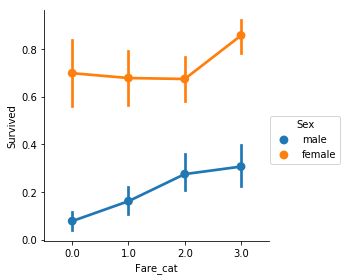

In [27]:
sns.factorplot('Fare_cat','Survived',data=df,hue='Sex')
df.drop(['Sex'],axis=1,inplace=True)

Добавям Family_Size, което е сбор от Parch и SibSp.

In [28]:
df['Family_Size']=df['Parch']+df['SibSp']

One hot encode-ваме и fare_cat и age_band.

In [29]:
def one_hot_fare_age(dataframe):
    fare_categories = dataframe.Fare_cat.unique()
    age_categories = dataframe.Age_band.unique()

    for f in fare_categories:
        fare = 'Fare_cat_' + f.astype(str)
        dataframe[fare] = (dataframe.Fare_cat == f).astype(float)

    for a in age_categories:
        age = 'Age_band_' + a.astype(str)
        dataframe[age] = (dataframe.Age_band == a).astype(float)

    dataframe.drop(['Age_band', 'Fare_cat'], axis=1, inplace=True)

In [30]:
one_hot_fare_age(df)

Може да пробваме да си поиграем с кабините. [Разположение на кабините](https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Titanic_cutaway_diagram.png/687px-Titanic_cutaway_diagram.png)

In [31]:
df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20',
       'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86',
       'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19',
       'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24',

In [32]:
df['Cabin'] = df['Cabin'].fillna('N')
df['Cabin'] = df['Cabin'].astype(str)
df['Cabin'] = df['Cabin'].astype(str).str[0]

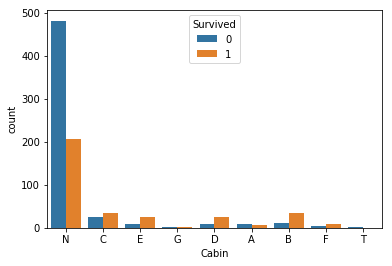

In [33]:
sns.countplot('Cabin', hue='Survived', data=df);

#### Виждаме, че повече от половината, за които няма данни дали са имали каюта са загинали. За сметка на това, от всички с каюти, повечето са оцелели. Един вариант е да one-hot encode-нем всички каюти (N значи без каюта), а другия е да ги комбинираме в различни категории според графиката (например A, BCDE, FG, N(и към него добавено T, за което има само един запис).

In [34]:
def one_hot_cabins(dataframe):
    dataframe['Cabin'] = dataframe['Cabin'].fillna('N')
    dataframe['Cabin'] = dataframe['Cabin'].astype(str)
    dataframe['Cabin'] = dataframe['Cabin'].astype(str).str[0]
    dataframe.loc[dataframe['Cabin']=='T','Cabin']='N'
    cabins = dataframe['Cabin'].unique()
    
    for c in cabins:
        dataframe[c] = (dataframe.Cabin == c).astype(float)
    
#     dataframe['CabinABC'] = ((dataframe.Cabin == 'A') | (dataframe.Cabin == 'B') | (dataframe.Cabin == 'C')).astype(float)
#     dataframe['CabinDE'] = ((dataframe.Cabin == 'D') | (dataframe.Cabin == 'E')).astype(float)
#     dataframe['CabinFG'] = ((dataframe.Cabin == 'F') | (dataframe.Cabin == 'G')).astype(float)    
#     dataframe['CabinN'] = ((dataframe.Cabin == 'N')).astype(float)
    
    dataframe = dataframe.drop(['Cabin'], axis=1)

In [35]:
one_hot_cabins(df)

In [36]:
(X, y) = get_x_y(df)

X: (891, 32)
y: (891,)


In [37]:
df.columns

Index(['Survived', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Male',
       'Female', 'Mr', 'Mrs', 'Miss', 'Master', 'EmbarkedC', 'EmbarkedQ',
       'EmbarkedS', 'Class1', 'Class2', 'Class3', 'Family_Size',
       'Fare_cat_0.0', 'Fare_cat_3.0', 'Fare_cat_1.0', 'Fare_cat_2.0',
       'Age_band_1.0', 'Age_band_2.0', 'Age_band_3.0', 'Age_band_0.0',
       'Age_band_4.0', 'N', 'C', 'E', 'G', 'D', 'A', 'B', 'F'],
      dtype='object')

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1337)

In [39]:
model = LogisticRegression().fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.839820359281
test score:  0.838565022422


## SVM

In [40]:
C=[0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.25, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.15, 1.2, 1.3]
gamma=[0.0005, 0.001, 0.005,0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]
kernel=['rbf','linear']
hyper={'kernel':kernel,'C':C,'gamma':gamma}
gd=GridSearchCV(estimator=SVC(),param_grid=hyper,verbose=True)
gd.fit(X,y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
0.835016835017
SVC(C=1.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


[Parallel(n_jobs=1)]: Done 1728 out of 1728 | elapsed:   54.2s finished


In [42]:
model=SVC(kernel='rbf',C=1.1,gamma=0.1, random_state=0)
model.fit(X_train,y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.84880239521
test score:  0.834080717489


## Random forest

In [43]:
n_estimators=range(50,500,50)
max_depths=[1,2,4,5,6,10,12,16,20]
hyper={'n_estimators':n_estimators,
           'max_depth':max_depths}
gd=GridSearchCV(estimator=RandomForestClassifier(random_state=0),param_grid=hyper,verbose=True)
gd.fit(X,y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
0.828282828283
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  1.8min finished


In [44]:
model = RandomForestClassifier(max_depth=5,n_estimators=50, random_state=0).fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.844311377246
test score:  0.834080717489


Да събмитнем в Kaggle.

In [45]:
test = pd.read_csv('data/test.csv', index_col=['PassengerId'])

test['Title'] = test.Name.str.extract('([A-Za-z]+)\.', expand=False)

test['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Mr','Mr','Mr','Mr','Mr','Mr', 'Mrs'],inplace=True)

test.loc[(test.Age.isnull()) & (test.Title == 'Mr'), 'Age'] = test[test.Title == 'Mr'].Age.mean()
test.loc[(test.Age.isnull()) & (test.Title == 'Mrs'), 'Age'] = test[test.Title == 'Mrs'].Age.mean()
test.loc[(test.Age.isnull()) & (test.Title == 'Miss'), 'Age'] = test[test.Title == 'Miss'].Age.mean()
test.loc[(test.Age.isnull()) & (test.Title == 'Master'), 'Age'] = test[test.Title == 'Master'].Age.mean()

test['Embarked'] = test['Embarked'].fillna('S')

test['Male']    = (test.Sex == 'male').astype(float)
test['Female']  = (test.Sex == 'female').astype(float)
test['Mr']      = (test.Title == 'Mr').astype(float)
test['Mrs']     = (test.Title == 'Mrs').astype(float)
test['Miss']    = (test.Title == 'Miss').astype(float)
test['Master']  = (test.Title == 'Master').astype(float)
test['EmbarkedC'] = (test.Embarked == 'C').astype(float)
test['EmbarkedQ'] = (test.Embarked == 'Q').astype(float)
test['EmbarkedS'] = (test.Embarked == 'S').astype(float)
test['Class1'] = (test.Pclass == 1).astype(float)
test['Class2'] = (test.Pclass == 2).astype(float)
test['Class3'] = (test.Pclass == 3).astype(float)

bin_age(test)

test['Fare'] = test['Fare'].fillna(test['Fare'].mean())
test['Fare_Range']=pd.qcut(test['Fare'],4)

bin_fare(test)

test['Family_Size']=test['Parch']+test['SibSp']

one_hot_fare_age(test)

one_hot_cabins(test)

test.drop(['Name', 'Sex', 'Ticket', 'Cabin','Embarked', 'Title', 'Fare_Range', 'Pclass'],axis=1,inplace=True)

In [46]:
predictions = model.predict(test)
frame = pd.DataFrame({
    'PassengerId': pd.read_csv('data/test.csv').PassengerId,
    'Survived': predictions
})
frame = frame.set_index('PassengerId')
frame.to_csv('data/predictions.csv')
frame.head(10)

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


## Максималният резултат, който постигнах в Kaggle е 0.80382, използвайки rbf SVM.

## [Класацията в Kaggle - Martin Kirilov](https://www.kaggle.com/c/titanic/leaderboard)

![score](score.png)